In [0]:
# Initialisation du notebook en important les différents modules nécessaires
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from collections import OrderedDict

# Initialisation du client PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Importation des modules Python nécessaires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

Ce notebook Colaboratory a été créé dans l'optique de déterminer, à partir des données de la banque mondiale, les pays où pourrait s'étendre l'entreprise Academy, spécialisée dans les contenus de formation en ligne. 

Les buts finaux de cette étude est de déterminer :
- Les pays avec un fort potentiel d'intérêt dans le développement de l'entreprise, et la priorité pour chacun d'entre eux.
- L'évolution de ces pays dans le futur proche. 

Pour ce faire, après avoir étudié les différents fichiers à notre disposition, nous allons trouver les différents indicateurs d'intérêt selon différentes variables afin d'en retirer des données intéressantes pour notre projet, puis en tirer les conclusions et points d'amélioration possibles.



# Sommaire
1. Les données de la banque mondiale
2. L'extraction des pays 
3. Recherche des indicateurs intéressants pour notre étude
4. Analyse des différents indicateurs

# Les données de la banque mondiale

Le fichier téléchargeable obtenu sur le site de la banque mondiale est en réalité un fichier compressé contenant 5 fichiers .CSV contenant chacun des informations complémentaire les uns des autres. Ces fichiers sont utilisables dans Colaboratory par utilisation de Google Drive : après déplacement des 5 fichiers dans le même dossier que celui du notebook, le lien du fichier est enregistré dans une variable et le code ou ID à la fin de l'URL utilisé pour trouver le fichier et le télécharger en tant que CSV. 

In [0]:
#Importation des données dans le notebook, à partir du Google Drive
link1="https://drive.google.com/open?id=16W2Wpb-VV5M-F7DhgHW6mPK0P4oByf2Z" 
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('EdStatsCountry.csv')  
data1 = pd.read_csv('EdStatsCountry.csv')
print ("Data1 importées")

link2="https://drive.google.com/open?id=1mn45ZVa0pMmqEc-_zQEF4mvONrFfBcDZ" 
fluff, id = link2.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('EdStatsCountry-Series.csv')  
data2 = pd.read_csv('EdStatsCountry-Series.csv')
print ("Data2 importées")

link3="https://drive.google.com/open?id=11Y--_6pTJJzEn5EHAzi9J7_M0aVZPmFa" 
fluff, id = link3.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('EdStatsData.csv')  
data3 = pd.read_csv('EdStatsData.csv')
print ("Data3 importées")

link4="https://drive.google.com/open?id=1UDozUDP88cNp-xn_8ZK4Zj7TM8lbWy2-" 
fluff, id = link4.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('EdStatsFootNote.csv')  
data4 = pd.read_csv('EdStatsFootNote.csv')
print ("Data4 importées")


link5="https://drive.google.com/open?id=1tkCqWOG2QQYeNCXLiVCheOtMgAv8PrMp" 
fluff, id = link5.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('EdStatsSeries.csv')  
data5 = pd.read_csv('EdStatsSeries.csv')
print ("Data5 importées")

Data1 importées
Data2 importées
Data3 importées
Data4 importées
Data5 importées


Le premier fichier, ou "'EdStatsCountry.csv" contient les différentes données possibles sur tous les pays existants dans le monde et contient 241 lignes et 32 colonnes. Tous les critères ne nous seront pas utiles : après un premier tri visuel de la liste des colonnes disponibles, nous considérons donc les critères "Country Code" (tous les noms de pays en abréviations de 3 lettres), "Short Name" (tous les noms de pays en dénomination courante), "Currency Unit" (la monnaie du pays, pouvant potentiellement être utile en cas de réflexion sur le fait de conserver un pays ou non vu que cela constituera une démarche de moins à faire) et "Region" (les différentes régions du monde, intéressantes pour obtenir des statistiques plus globales et moins nombreuses).



In [0]:
# Affichage des données existantes sur les données des deux premiers fichiers
print ("Data1 : ")
print (data1.columns)
print ("Nombre de lignes : ",data1.shape[0])
print ("Nombre de colonnes : ",data1.shape[1])


Data1 : 
Index(['Country Code', 'Short Name', 'Table Name', 'Long Name', '2-alpha code',
       'Currency Unit', 'Special Notes', 'Region', 'Income Group', 'WB-2 code',
       'National accounts base year', 'National accounts reference year',
       'SNA price valuation', 'Lending category', 'Other groups',
       'System of National Accounts', 'Alternative conversion factor',
       'PPP survey year', 'Balance of Payments Manual in use',
       'External debt Reporting status', 'System of trade',
       'Government Accounting concept', 'IMF data dissemination standard',
       'Latest population census', 'Latest household survey',
       'Source of most recent Income and expenditure data',
       'Vital registration complete', 'Latest agricultural census',
       'Latest industrial data', 'Latest trade data',
       'Latest water withdrawal data', 'Unnamed: 31'],
      dtype='object')
Nombre de lignes :  241
Nombre de colonnes :  32


Si nous conservons donc uniquement ces quatre critères, il est essentiel de regarder s'ils contiennent suffisamment d'information pour nous être utiles par la suite. 


In [0]:
print (data1[['Country Code','Short Name','Currency Unit','Region']].describe(include='all'))

       Country Code Short Name Currency Unit                 Region
count           241        241           215                    214
unique          241        241           152                      7
top             SYC    Albania          Euro  Europe & Central Asia
freq              1          1            23                     57


Il y a donc un total de 241 pays dans le monde potentiellement à considérer dans notre étude. Cependant, nous ne connaissons pas toutes les informations sur la monnaie et les régions de chaque pays. 
Il est également à noter qu'un tri sera sûrement nécessaire dans les pays : des pays trop petits en termes de population ne seront sûrement pas intéressants pour faire investir l'entreprise en termes de rentabilité. Nous pouvons également supposer que de trop petits pays n'auront pas d'informations à étudier. Pour commencer à faire un premier tri, il serait intéressant d'étudier un second fichier pour voir le nombre de pays présents. Contrairement à la monnaie, où une complétion des données peut être compliquée, l'existence de seulement 7 régions pourrait rendre une complétion manuelle plus simple, selon le nombre de pays à région manquante. 

Le second fichier, ou "EdStatsCountry-Series.csv" contient les différents critères possibles pour les pays, ainsi que la description de chacun d'entre eux. Il contient 613 lignes pour 4 colonnes.


In [0]:
print ("Data2 :")
print (data2.columns)
print ("Nombre de lignes : ",data2.shape[0])
print ("Nombre de colonnes : ",data2.shape[1])


Data2 :
Index(['CountryCode', 'SeriesCode', 'DESCRIPTION', 'Unnamed: 3'], dtype='object')
Nombre de lignes :  613
Nombre de colonnes :  4


In [0]:
print (data2[['CountryCode','SeriesCode']].describe(include='all'))

       CountryCode   SeriesCode
count          613          613
unique         211           21
top            MDA  SP.POP.TOTL
freq            18          211


Nous pouvons voir ici qu'il n'y a que 211 pays indiqués, ce qui nous fait une bonne base pour travailler par la suite. Il sera cependant intéressant de voir les pays non présents dans ce second fichier par rapport au premier, histoire de voir si ce sont de petits ou de gros pays. 

Pour les SeriesCodes, ou les critères utilisables par la suite pour le choix des bons pays, nous pouvons cependant voir que tous ne sont pas dans ce fichier : il n'y en a ici que 21, alors que des milliers sont présents sur le site. Nous pouvons donc supposer que les autres sont présents dans un autre fichier. Cette hypothèse est confirmée par le fait qu'aucune valeur n'est indiquée pour chacun des critères. 

Le troisième fichier, ou "EdStatsData.csv", contient justement les données sur les indicateurs. On remarquera d'ailleurs que les SeriesCode ont changé de nom pour s'appeler "Indicator Code", ce qui sera important pour rassembler toutes les données de fichiers. Le fichier contient 886930 lignes pour 70 colonnes.

In [0]:
print ("Data3 :")
print (data3.columns)
print ("Nombre de lignes : ",data3.shape[0])
print ("Nombre de colonnes : ",data3.shape[1])

Data3 :
Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978',
       '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987',
       '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996',
       '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2020', '2025', '2030', '2035', '2040', '2045',
       '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090',
       '2095', '2100', 'Unnamed: 69'],
      dtype='object')
Nombre de lignes :  886930
Nombre de colonnes :  70


In [0]:
print (data3[['Country Code','Indicator Code']].describe(include='all'))
print (data3[['2013','2014','2015','2016','2017']].describe(include='all'))
print (data3[['2020','2025','2030','2035','2040']].describe(include='all'))

       Country Code   Indicator Code
count        886930           886930
unique          242             3665
top             DMA  OECD.TSAL.0.E10
freq           3665              242
               2013          2014          2015          2016        2017
count  1.375090e+05  1.137890e+05  1.310580e+05  1.646000e+04  143.000000
mean   2.425332e+10  2.678449e+10  2.353720e+10  1.934411e+11    2.160839
std    9.513016e+11  1.023180e+12  9.732465e+11  2.839188e+12    0.810584
min   -6.157480e+05 -8.900000e+01 -2.467847e+00 -1.797539e+00    1.000000
25%    1.306113e+01  1.614639e+01  4.100000e-01  1.826761e+01    2.000000
50%    1.000000e+02  1.000000e+02  5.235000e+01  6.264000e+03    2.000000
75%    1.426480e+05  1.636440e+05  6.153575e+04  5.939590e+05    3.000000
max    1.054580e+14  1.108060e+14  1.156198e+14  1.206030e+14    4.000000
               2020          2025          2030          2035          2040
count  5.143600e+04  5.143600e+04  5.143600e+04  5.143600e+04  5.143600e+

Dans ce fichier, il y a 242 pays, ce qui est encore un nombre différent et encore plus nombreux que le premier fichier : un tri devrait être fait à ce niveau. Nous pouvons aussi voir que les milliers d'indicateurs' sont également là, avec toutes les valeurs correspondantes. Les valeurs sont présentes par années, de 1970 à 2100 (de 5 en 5 pour les années futures). Nous n'avons cependant pas besoin de tant d'années, et pouvons faire une sélection parmi celles disponibles. 

Si nous pouvons voir que l'année considérée comme "actuelle" dans la banque mondiale, à savoir 2017,  ne possède que très peu de valeurs, les données du passé proche (les 5 dernières années) et du futur plus lointain (de 2020 à 2040) sont au contraire plutôt complètes. L'intérêt sera donc ici de trouver les critères à la fois suffisamment présents dans les pays conservés et avec des valeurs représentatives pour le passé proche et le futur, ou avec un moyen de les calculer. 

Le quatrième fichier semble être bâti sur le même modèle que le second, à savoir des pays et des indicateurs avec leur description. Une année est disponible, sûrement la dernière année de disponibilité des indicateurs en question. Il contient 643638 lignes pour 5 colonnes.

In [0]:
print ("Data4 :")
print (data4.columns)
print ("Nombre de lignes : ",data4.shape[0])
print ("Nombre de colonnes : ",data4.shape[1])

Data4 :
Index(['CountryCode', 'SeriesCode', 'Year', 'DESCRIPTION', 'Unnamed: 4'], dtype='object')
Nombre de lignes :  643638
Nombre de colonnes :  5


Vu les données disponibles, nous pouvons supposer que ce fichier ne nous apportera pas plus d'infirmation : vu qu'il ne contient pas de valeur associée, il risque de n'y avoir aucun indicateur à rajouter à part de ce fichier.


In [0]:
print (data4[['CountryCode','SeriesCode','Year']].describe(include='all'))

       CountryCode   SeriesCode    Year
count       643638       643638  643638
unique         239         1558      56
top            LIC  SH.DYN.MORT  YR2004
freq          7320         9226   27128


Enfin, le cinquième fichier va apporter toutes les informations nécessaires sur les différents indicateurs disponibles, comme pouvait le faire le premier fichier pour les pays. Ce fichier nous sera donc essentiellement utile pour expliquer les critères qui vont être extraits avec nos différents filtres d'extraction. Il contient 3665 lignes pour 21 colonnes : nous pouvons donc supposer qu'il y aura bien la description de tous les SeriesCode du troisième fichier

In [0]:
print ("Data5 :")
print (data5.columns)
print ("Nombre de lignes : ",data5.shape[0])
print ("Nombre de colonnes : ",data5.shape[1])

Data5 :
Index(['Series Code', 'Topic', 'Indicator Name', 'Short definition',
       'Long definition', 'Unit of measure', 'Periodicity', 'Base Period',
       'Other notes', 'Aggregation method', 'Limitations and exceptions',
       'Notes from original source', 'General comments', 'Source',
       'Statistical concept and methodology', 'Development relevance',
       'Related source links', 'Other web links', 'Related indicators',
       'License Type', 'Unnamed: 20'],
      dtype='object')
Nombre de lignes :  3665
Nombre de colonnes :  21


# Extraction des pays

Le premier point de ce projet va donc être d'extraire les pays pouvant potentiellement nous intéresser.

Nous commençons tout d'abord par rassembler les deux premiers fichiers, afin de commencer à obtenir un début de DataFrame pouvant regrouper les pays et les indicateurs. Cependant, nous avons soulevé un point intéressant précédemment : les deux fichiers ne contiennent pas le même nombre de pays, et il est nécessaire de vérifier les pays supprimés. Pour une meilleure compréhension, nous mettons d'ailleurs en place une fonction reliant les Country Codes et les Short Names.

In [0]:
#Fonction indiquant les noms courts à partir des codes de pays
def country_series(list): 
  listseries=[]
  for x in list:
    el=data1[data1['Country Code'] == x]
    listseries.append(el['Short Name'])
  return (listseries)



Nous pouvons voir que les pays supprimés entre les deux fichiers ne sont en aucun cas de gros pays. Il s'agit essentiellement de régions du globe (alors que nous avons une mesure plus précise à ce sujet par l'utilisation de la colonne "Region" du premier fichier qui va regrouper chaque pays) ou de petits pays. Nous pourrons donc faire un merge des deux fichiers en considérant le fichier avec le moins de pays, à savoir le deuxième fichier.



In [0]:
# Tri des country codes, afin de déterminer si les pays de data1 manquants dans data2 sont des pays "importants" ou à considérer dans l'analyse
data1country=data1['Country Code'].unique()
data2country=data2['CountryCode'].unique()
countriestosubstract=np.setxor1d(data1country,data2country) # Indiquer les valeurs différentes entre les tableaux numpy
print ("Pays présents dans un seul des deux fichiers :")
print(country_series(countriestosubstract)) # Sortir les noms des pays, au lieu des codes, pour une meilleure visibilité



Pays présents dans un seul des deux fichiers :
[5    Arab World
Name: Short Name, dtype: object, 47    Curaçao
Name: Short Name, dtype: object, 57    East Asia & Pacific (developing only)
Name: Short Name, dtype: object, 58    East Asia & Pacific (all income levels)
Name: Short Name, dtype: object, 59    Europe & Central Asia (developing only)
Name: Short Name, dtype: object, 60    Europe & Central Asia (all income levels)
Name: Short Name, dtype: object, 63    Euro area
Name: Short Name, dtype: object, 68    European Union
Name: Short Name, dtype: object, 89    High income
Name: Short Name, dtype: object, 92    Heavily indebted poor countries (HIPC)
Name: Short Name, dtype: object, 116    Latin America & Caribbean (developing only)
Name: Short Name, dtype: object, 122    Latin America & Caribbean (all income levels)
Name: Short Name, dtype: object, 123    Least developed countries: UN classification
Name: Short Name, dtype: object, 124    Low income
Name: Short Name, dtype: object, 12

Nous pouvons donc, par ce merge et un tri des catégories selon les discussions précédentes, voir que nous partons pour le moment sur un pool de 211 pays et de 21 critères. Le nombre de critères n'est cependant pas représentatif vu qu'il est de base très faible dans le deuxième fichier par rapport au premier. Les 7 régions du globe sont représentées, même si on notera la sur-représentation de pays d'Europe et d'Asie Centrale avec 198 pays en faisant partie. Nous pouvons donc supposer que l'extension d'Academy se fera essentiellement dans cette région.  

In [0]:
data12=pd.merge(data2,data1, how="left", left_on="CountryCode", right_on="Country Code") # Utilisation des Country Code de data2 pour la suite, avec le Short Name associé ainsi que leur région
data12=data12[['CountryCode','Short Name','Region','SeriesCode']]
print ("Données des pays conservés :")
print (data12.describe (include='all'))




Données des pays conservés :
       CountryCode Short Name                 Region   SeriesCode
count          613        613                    611          613
unique         211        211                      7           21
top            MDA    Moldova  Europe & Central Asia  SP.POP.TOTL
freq            18         18                    198          211


Nous pouvons cependant voir que des pays n'ont pas de région : nous regardons donc lesquelles. Au final, il s'avère qu'un seul pays n'a pas de région : Gibraltar. Même s'il s'agit d'un petit pays, sa proximité avec l'Espagne en fait tout de même un potentiel candidat : nous rajoutons donc manuellement sa région et allons maintenant à la recherche des petits pays, afin d'en faire finalement le tri.

In [0]:
# Sélection du pays sans région et remplissage par la bonne valeur
data12new=data12.fillna(0)
masque=data12new["Region"]==0
data12region=data12new[masque] # On sort le pays dont la région manque 
print (data12region)
data12.loc[data12['Short Name'] == "Gibraltar",'Region']='Europe & Central Asia'

    CountryCode Short Name Region   SeriesCode
200         GIB  Gibraltar      0  SP.POP.TOTL
201         GIB  Gibraltar      0  SP.POP.GROW


Tout d'abord, nous commençons à trier le merge entre les deux premiers fichiers afin de n'en tirer que les lignes avec la population totale. Nous pouvons d'ailleurs voir que la population totale est indiquée pour chacun des pays. 

In [0]:
# Sélection de la population par pays
masque=data12["SeriesCode"]=="SP.POP.TOTL" 
data12poptot=data12[masque] # Création de la data rassemblant les éléments intéressants de data1 et data2 pour la population totale
print (data12poptot["CountryCode"].describe(include="all"))

count     211
unique    211
top       SYC
freq        1
Name: CountryCode, dtype: object


Il faut maintenant récupérer les valeurs en mergeant notre fichier avec le troisième fichier, et ne conserver que les années intéressantes pour notre étude. Comme nous pouvons le voir, des valeurs ne sont disponibles que jusqu'à 2016 : il faudrait voir pour une complétion possible avec l'indicateur de croissance de la population.  

In [0]:
# Tri des pays selon la taille de leur population
datapoptotmerge=pd.merge(data12poptot,data3,how="inner",left_on=["CountryCode","SeriesCode"],right_on=["Country Code","Indicator Code"])
print (datapoptotmerge[["2013","2014","2015","2016","2017","2020","2025"]].describe(include="all"))
print (datapoptotmerge[["2030","2035","2040","2045","2050","2055","2060"]].describe(include="all"))
print (datapoptotmerge[["2065","2070","2075","2080","2085","2090","2095"]].describe(include="all"))
datapoptottri=datapoptotmerge[["CountryCode","Short Name","Region","2013","2014","2015","2016"]] # Tri des colonnes pour ne conserver que les années intéressantes pour l'analyse

               2013          2014          2015          2016  2017  2020  2025
count  2.100000e+02  2.100000e+02  2.100000e+02  2.100000e+02   0.0   0.0   0.0
mean   3.401631e+07  3.442405e+07  3.483218e+07  3.524365e+07   NaN   NaN   NaN
std    1.331093e+08  1.342548e+08  1.354003e+08  1.365662e+08   NaN   NaN   NaN
min    1.081900e+04  1.090800e+04  1.100100e+04  1.109700e+04   NaN   NaN   NaN
25%    9.434525e+05  9.664790e+05  9.858068e+05  9.992810e+05   NaN   NaN   NaN
50%    6.358258e+06  6.416886e+06  6.475798e+06  6.535015e+06   NaN   NaN   NaN
75%    2.271244e+07  2.322836e+07  2.361912e+07  2.401935e+07   NaN   NaN   NaN
max    1.357380e+09  1.364270e+09  1.371220e+09  1.378665e+09   NaN   NaN   NaN
       2030  2035  2040  2045  2050  2055  2060
count   0.0   0.0   0.0   0.0   0.0   0.0   0.0
mean    NaN   NaN   NaN   NaN   NaN   NaN   NaN
std     NaN   NaN   NaN   NaN   NaN   NaN   NaN
min     NaN   NaN   NaN   NaN   NaN   NaN   NaN
25%     NaN   NaN   NaN   NaN   NaN   Na

Nous décidons que les petits pays sont les pays ayant moins de 1000000 habitants : il y en aurait tout de même 53. Il a tout de même fallu faire un tri manuel pour savoir quels petits pays pourraient être intéressants, essentiellement par la proximité avec un autre pays beaucoup plus grand : nous en avons conservé 11, ce qui amène à un total de 167 pays.

In [0]:
masque=(datapoptottri["2016"]<=1000000) #Trouver les petits pays pour sélectionner
datapoptotinf=datapoptottri[masque]
print ("Nombre de petits pays : ",datapoptotinf.shape[0])

masque=(datapoptottri["2016"]>=1000000) | (datapoptottri["Short Name"]=="Andorra") | (datapoptottri["Short Name"]=="Gibraltar") | (datapoptottri["Short Name"]=="Guyana") | (datapoptottri["Short Name"]=="Iceland") | (datapoptottri["Short Name"]=="Liechtenstein") | (datapoptottri["Short Name"]=="Luxembourg") | (datapoptottri["Short Name"]=="Macao SAR, China") | (datapoptottri["Short Name"]=="Monaco") | (datapoptottri["Short Name"]=="Montengero") | (datapoptottri["Short Name"]=="San Marino") | (datapoptottri["Short Name"]=="Suriname")
datapoptot=datapoptottri[masque] # Choix des pays en gardant les pays limitrophes à de gros pays : Andorre (France et Espagne), Gibraltar (Espagne), Guyane (Venezuela ?), Islande (?), Liechtenstein (Autriche-Suisse), Luxembourg, Macao (Chine),
#Monaco (France), Montenegro (?), San Marino (Italie), Suriname
print ("Nombre de pays pris en compte : ",datapoptot.shape[0])

Nombre de petits pays :  53
Nombre de pays pris en compte :  167


A partir de ce fichier, nous pouvons donc créer un DataFrame de base, contenant les différents pays utilisés, leur nom courant, leur région et les différents indicateurs associés.

In [0]:
# Création d'un DataFrame base de pays
db=pd.merge(datapoptot,data3,how="inner",left_on=["CountryCode"],right_on=["Country Code"])
database=db[["CountryCode","Short Name","Region","Indicator Code"]]
print ("Aperçu du fichier de base de notre étude")
print (database.head(10))

Aperçu du fichier de base de notre étude
  CountryCode   Short Name      Region  Indicator Code
0         AFG  Afghanistan  South Asia      UIS.NERA.2
1         AFG  Afghanistan  South Asia    UIS.NERA.2.F
2         AFG  Afghanistan  South Asia  UIS.NERA.2.GPI
3         AFG  Afghanistan  South Asia    UIS.NERA.2.M
4         AFG  Afghanistan  South Asia     SE.PRM.TENR
5         AFG  Afghanistan  South Asia  SE.PRM.TENR.FE
6         AFG  Afghanistan  South Asia  UIS.NERA.1.GPI
7         AFG  Afghanistan  South Asia  SE.PRM.TENR.MA
8         AFG  Afghanistan  South Asia      UIS.NERA.3
9         AFG  Afghanistan  South Asia    UIS.NERA.3.F


# Recherche des indicateurs intéressants pour notre étude

Nous avons vu précédemment qu'il existe 3665 indicateurs dans la banque mondiale, ce qui est beaucoup trop important pour nous. Le premier tri serait déjà de n'extraire que les indicateurs existant pour une grande majorité des pays présents dans notre DataFrame. Nous avons extrait 167 pays dont 11 petits n'ayant peut-être pas beaucoup de données complétées. Pour notre étude, nous considérons donc un indicateur comme pertinent s'il est complété pour au moins 150 pays : nous écrivons donc une fonction pour cet indicateur. Cependant, cette méthode ne semble pas distinguer les bons indicateurs, car tous les indicateurs sont présents pour plus de 150 pays. Une autre méthode pourrait être utilisée, par utilisation du cinquième fichier.

In [0]:
# Recherche des indicateurs intéressants globalement (Series Code / Indicator Code)
def SeriesToConserv(list):
  occ={}
  occ2={}
  for u in list.unique():
    occ[u]=0
  for v in list:
    occ[v] = occ[v]+1
  for cle, valeur in occ.items():
    if valeur >= 150:
      occ2[cle]=valeur
  #occlist=[*occ2] # Transformer les clés du dictionnaire en une liste
  return occ2

# Recherche des indicateurs intéressants dans le data 3 (Indicator Code)
print ("Indicateurs intéressants pour notre étude, et leurs occurences")
data3tri=pd.merge(database,data3,how="inner",left_on=["CountryCode","Indicator Code"],right_on=["Country Code",'Indicator Code'])
print (data3tri[["Country Code","Indicator Code"]].describe(include="all"))
data3partieltri=data3tri[["Country Code","Indicator Code","2013","2014","2015","2016","2017","2020","2025","2030","2035","2040"]]
occ=SeriesToConserv(data3partieltri["Indicator Code"])
print (occ)

Indicateurs intéressants pour notre étude, et leurs occurences
       Country Code   Indicator Code
count        612055           612055
unique          167             3665
top             PRI  OECD.TSAL.0.E10
freq           3665              167
{'UIS.NERA.2': 167, 'UIS.NERA.2.F': 167, 'UIS.NERA.2.GPI': 167, 'UIS.NERA.2.M': 167, 'SE.PRM.TENR': 167, 'SE.PRM.TENR.FE': 167, 'UIS.NERA.1.GPI': 167, 'SE.PRM.TENR.MA': 167, 'UIS.NERA.3': 167, 'UIS.NERA.3.F': 167, 'UIS.NERA.3.GPI': 167, 'UIS.NERA.3.M': 167, 'UIS.NIRA.1': 167, 'UIS.NIRA.1.F': 167, 'UIS.NIRA.1.GPI': 167, 'UIS.NIRA.1.M': 167, 'UIS.LPP.AG15T99': 167, 'UIS.LP.AG15T99': 167, 'UIS.LP.AG15T99.F': 167, 'UIS.LP.AG15T99.M': 167, 'SE.ADT.LITR.ZS': 167, 'SE.ADT.LITR.FE.ZS': 167, 'UIS.LR.AG15T99.GPI': 167, 'SE.ADT.LITR.MA.ZS': 167, 'UIS.AFR.AGRADMG.1.PU': 167, 'UIS.AFR.PBR.1.G1.PU.MATH': 167, 'UIS.AFR.PBR.1.G2.PU.MATH': 167, 'UIS.AFR.PBR.1.G3.PU.MATH': 167, 'UIS.AFR.PBR.1.G4.PU.MATH': 167, 'UIS.AFR.PBR.1.G5.PU.MATH': 167, 'UIS.AFR.PBR.1.G6

Précédemment, nous avons pu voir que le cinquième fichier contient une colonne "Topic" rassemblant par catégorie les différents indicateurs : n'extraire que les indicateurs concernant l'éducation, la population et l'Internet pourrait donc être intéressant. Avec ce tri, nous récupérons 629 indicateurs différents, soit 1/6 du total environ. Ce nombre est cependant encore trop grand, nous allons trier topic par topic.


In [0]:
print (data5["Topic"].unique())
masque=(data5["Topic"]=='Infrastructure: Communications') | (data5["Topic"]=='Secondary') | (data5["Topic"]=='Tertiary') | (data5["Topic"]=='Population')
data5crit=data5[masque]
print (data5crit[["Indicator Name"]].describe(include="all"))

['Attainment' 'Education Equality' 'Infrastructure: Communications'
 'Learning Outcomes'
 'Economic Policy & Debt: National accounts: US$ at current prices: Aggregate indicators'
 'Economic Policy & Debt: National accounts: US$ at constant 2010 prices: Aggregate indicators'
 'Economic Policy & Debt: Purchasing power parity'
 'Economic Policy & Debt: National accounts: Atlas GNI & GNI per capita'
 'Teachers' 'Education Management Information Systems (SABER)'
 'Early Child Development (SABER)' 'Engaging the Private Sector (SABER)'
 'School Health and School Feeding (SABER)'
 'School Autonomy and Accountability (SABER)' 'School Finance (SABER)'
 'Student Assessment (SABER)' 'Teachers (SABER)'
 'Tertiary Education (SABER)' 'Workforce Development (SABER)' 'Literacy'
 'Background' 'Primary' 'Secondary' 'Tertiary' 'Early Childhood Education'
 'Pre-Primary' 'Expenditures' 'Health: Risk factors' 'Health: Mortality'
 'Social Protection & Labor: Labor force structure' 'Laber'
 'Social Protection 

Nous commençons par le topic "Infrastructure : Communications", car les cours d'Academy étant dispensés par Internet, il est essentiel que les pays disposent d'un grand nombre d'utilisateurs d'Internet. Nous pouvons donc conserver le SeriesCode "IT.NET.USER.P2" pour la suite.

In [0]:
masque=data5["Topic"]=='Infrastructure: Communications'
data5critint=data5[masque]
print (data5critint[["Series Code","Indicator Name"]])


        Series Code                       Indicator Name
610  IT.CMP.PCMP.P2  Personal computers (per 100 people)
611  IT.NET.USER.P2      Internet users (per 100 people)


Pour le topic "Population", nous pouvons voir si d'autres indicateurs peuvent être utilisés, en plus de l'indicateur de croissance de la population ("SP.POP.GROW") disponible dans le fichier 2. Nous pouvons voir que les indicateurs ici présents ne sont finalement pas intéressants pour nous : en effet, les indicateurs reposent essentiellement sur les âges de la population, ce qui ne nous intéressent pas ici, tout comme une distinction homme-femme. 

In [0]:
masque=data5["Topic"]=='Population'
data5critpop=data5[masque]
print (len(data5critpop["Indicator Name"]))
print (data5critpop.iloc[:50,[0,2]])
print (data5critpop.iloc[50:100,[0,2]])
print (data5critpop.iloc[100:150,[0,2]])
print (data5critpop.iloc[150:200,[0,2]])
print (data5critpop.iloc[200:,[0,2]])

213
            Series Code                  Indicator Name
2405  SP.POP.0305.FE.UN    Population, ages 3-5, female
2406  SP.POP.0305.MA.UN      Population, ages 3-5, male
2407  SP.POP.0305.TO.UN     Population, ages 3-5, total
2408  SP.POP.0406.FE.UN    Population, ages 4-6, female
2409  SP.POP.0406.MA.UN      Population, ages 4-6, male
2410  SP.POP.0406.TO.UN     Population, ages 4-6, total
2411  SP.POP.0509.FE.UN    Population, ages 5-9, female
2412  SP.POP.0509.MA.UN      Population, ages 5-9, male
2413  SP.POP.0509.TO.UN     Population, ages 5-9, total
2414  SP.POP.0510.FE.UN   Population, ages 5-10, female
2415  SP.POP.0510.MA.UN     Population, ages 5-10, male
2416  SP.POP.0510.TO.UN    Population, ages 5-10, total
2417  SP.POP.0511.FE.UN   Population, ages 5-11, female
2418  SP.POP.0511.MA.UN     Population, ages 5-11, male
2419  SP.POP.0511.TO.UN    Population, ages 5-11, total
2420  SP.POP.0609.FE.UN    Population, ages 6-9, female
2421  SP.POP.0609.MA.UN      Population, age

Un autre indicateur par pays pouvant également être intéressant pourrait être le PIB (ou GDP en anglais), et trouver ce indicateur étant quelque peu compliqué juste avec les Topics : la recherche directe sur le site de la banque mondiale a donné le bon indicateur, à savoir "NY.GDP.MKTP.CD". Nous ajoutons également "NY.GDP.PCAP.CD" qui est le PIB par habitant.


In [0]:
masque=(data5["Series Code"]=="NY.GDP.MKTP.CD") |(data5["Series Code"]=="NY.GDP.PCAP.CD") 
pib=data5[masque]
print (pib[["Series Code","Indicator Name"]])

         Series Code                Indicator Name
1658  NY.GDP.MKTP.CD             GDP (current US$)
1662  NY.GDP.PCAP.CD  GDP per capita (current US$)


Pour les indicateurs d'éducation, nous avons besoin de prendre les indicateurs correspondant au secondaire (niveau lycée) et tertiaire (niveau université). Le plus important pour nous serait de savoir le taux de scolarisation pour chacun des niveaux, plus exactement le net où l'âge n'est pas pris en compte. Le problème est qu'aucun indicateur n'est dicernable si facilement, vu que plusieurs ont des noms identiques. Il serait donc intéressant de voir le taux de remplissage de chaque indicateur pour les pays souhaités afin de choisir les indicateurs les plus indicatifs pour nous.

In [0]:
masque=(data5["Topic"]=='Secondary')
data5critsec=data5[masque]
print (len(data5critsec["Indicator Name"]))
print (data5critsec.iloc[:50,[0,2]])
print (data5critsec.iloc[50:100,[0,2]])
print (data5critsec.iloc[100:150,[0,2]])
print (data5critsec.iloc[150:200,[0,2]])
print (data5critsec.iloc[200:,[0,2]])

256
                       Series Code                                     Indicator Name
2218             SE.ENR.PRSC.FM.ZS  Gross enrolment ratio, primary and secondary, ...
2219             SE.ENR.SECO.FM.ZS  Gross enrolment ratio, secondary, gender parit...
2287                   SE.SEC.AGES  Official entrance age to lower secondary educa...
2288          SE.SEC.CMPT.LO.FE.ZS        Lower secondary completion rate, female (%)
2289          SE.SEC.CMPT.LO.MA.ZS          Lower secondary completion rate, male (%)
2290             SE.SEC.CMPT.LO.ZS    Lower secondary completion rate, both sexes (%)
2291                   SE.SEC.DURS  Theoretical duration of secondary education (y...
2292               SE.SEC.DURS.LO   Theoretical duration of lower secondary educat...
2293                SE.SEC.DURS.UP  Theoretical duration of upper secondary educat...
2294                   SE.SEC.ENRL  Enrolment in secondary education, both sexes (...
2295                SE.SEC.ENRL.FE  Enrolment in s

Lors de l'étude de tous les indicateurs, nous pouvons déjà voir qu'aucun indicateur n'a de données à partir de 2017, sans possibilité de deviner les valeurs. Nous pouvons donc regarder le taux de remplissage qu'entre les années 2013 et 2016 inclus. De plus, nous savons que les données nous intéressant sont des données d'enrolment ou d'inscription, donc nous pouvons faire un tri par rapport à cet élément. 


In [0]:
critsec=pd.merge(data3,data5critsec,how="inner",left_on=["Indicator Code"],right_on=["Series Code"])
critsec=critsec[["Country Code","Indicator Code","Indicator Name_x",'2013', '2014','2015', '2016', '2017', '2020', '2025', '2030', '2035', '2040']]
sec=pd.merge(database,critsec,how="inner",left_on=["CountryCode","Indicator Code"],right_on=["Country Code","Indicator Code"])
print (sec[['2013', '2014','2015', '2016', '2017']].describe(include="all"))
print (sec[['2020', '2025', '2030', '2035', '2040']].describe(include="all"))

               2013          2014          2015          2016  2017
count  2.064400e+04  1.609500e+04  3.910000e+03  5.660000e+02   0.0
mean   2.171172e+05  1.978353e+05  3.438409e+05  7.350429e+04   NaN
std    2.303078e+06  2.214645e+06  3.924768e+06  3.860662e+05   NaN
min    0.000000e+00  0.000000e+00  0.000000e+00  5.437000e-02   NaN
25%    6.101815e+00  8.477585e+00  1.092410e+01  4.000000e+00   NaN
50%    5.180035e+01  6.632640e+01  5.210420e+01  8.000000e+00   NaN
75%    1.295891e+02  9.995000e+02  1.034588e+02  1.300000e+01   NaN
max    1.194005e+08  1.294390e+08  1.295421e+08  3.908744e+06   NaN
       2020  2025  2030  2035  2040
count   0.0   0.0   0.0   0.0   0.0
mean    NaN   NaN   NaN   NaN   NaN
std     NaN   NaN   NaN   NaN   NaN
min     NaN   NaN   NaN   NaN   NaN
25%     NaN   NaN   NaN   NaN   NaN
50%     NaN   NaN   NaN   NaN   NaN
75%     NaN   NaN   NaN   NaN   NaN
max     NaN   NaN   NaN   NaN   NaN


Nous pouvons voir qu'il n'y a que trois indicateurs avec un remplissage intéressant sur tous les indicateurs du secondaire :
* SE.SEC.AGES : âge d'entrée dans le secondaire
* SE.SEC.DURS : durée théorique dans le secondaire
* SE.SEC.DURS.UP : durée théorique dans le secondaire supérieur

Ces données ne sont cependant pas du tout celles nous intéressant. Regardons donc les indicateurs correspondant à l'enrolment.



In [0]:
critsec=sec.groupby("Indicator Code")
countcritsec=critsec[["2013","2014","2015","2016"]].count()
print ((countcritsec.sort_values(by = ['2016',"2015","2014","2013"], ascending = False)).head(10))

masque=(data5["Series Code"]=="SE.SEC.AGES") | (data5["Series Code"]=="SE.SEC.DURS") | (data5["Series Code"]=="SE.SEC.DURS.UP")
critsectri=data5[masque]
print (critsectri.columns)
print (critsectri[["Series Code","Indicator Name"]])

                      2013  2014  2015  2016
Indicator Code                              
SE.SEC.AGES            166   166   166   136
SE.SEC.DURS            166   166   166   136
SE.SEC.DURS.UP         166   166   166   136
SE.SEC.ENRL.GC         133   126   114     7
SE.SEC.ENRL.GC.FE      132   126   114     7
SE.SEC.ENRL.GC.FE.ZS   132   126   114     7
SE.SEC.ENRR.LO         127   122   105     7
SE.SEC.ENRR.LO.FE      126   121   105     7
SE.SEC.ENRR.LO.MA      126   121   105     7
SE.SEC.ENRL            121   116   100     5
Index(['Series Code', 'Topic', 'Indicator Name', 'Short definition',
       'Long definition', 'Unit of measure', 'Periodicity', 'Base Period',
       'Other notes', 'Aggregation method', 'Limitations and exceptions',
       'Notes from original source', 'General comments', 'Source',
       'Statistical concept and methodology', 'Development relevance',
       'Related source links', 'Other web links', 'Related indicators',
       'License Type', 'Unnamed:

Le problème est que les indicateurs sur l'enrolment ne donnent pas non plus des résultats concernant tous les pays. L'déal pour nous serait donc de prendre un indicateur à la fois avec de nombreux éléments et le plus pertinent pour notre étude. Nous choisirons donc le indicateur "SE.SEC.ENRR.UP" qui indique les pourcentages d'inscription en secondaire supérieur, qui correspond à notre niveau lycée. Il faudra cependant le traduire en nombre de personnes pour une meilleure pertinence.



In [0]:
masque=sec["Indicator Name_x"].str.contains("enrolment")
sectri=sec[masque]
secgb=sectri.groupby('Indicator Code')
countsec=secgb[["2013","2014","2015","2016"]].count()
print ((countsec.sort_values(by = ['2016',"2015","2014","2013"], ascending = False)).head(10))

masque=(data5["Series Code"]=="SE.SEC.ENRR.LO") | (data5["Series Code"]=="SE.SEC.ENRR") | (data5["Series Code"]=="SE.ENR.SECO.FM.ZS") | (data5["Series Code"]=="SE.SEC.ENRR.UP")
critsectri=data5[masque]
print (critsectri[["Series Code","Indicator Name"]])

                   2013  2014  2015  2016
Indicator Code                           
SE.SEC.ENRR.LO      127   122   105     7
SE.SEC.ENRR.LO.FE   126   121   105     7
SE.SEC.ENRR.LO.MA   126   121   105     7
SE.SEC.ENRR         116   112    96     5
SE.ENR.SECO.FM.ZS   113   110    95     5
SE.SEC.ENRR.FE      113   110    95     5
SE.SEC.ENRR.MA      113   110    95     5
SE.SEC.ENRR.UP      118   111    94     5
SE.SEC.ENRR.UP.MA   116   109    93     5
SE.ENR.PRSC.FM.ZS   108   107    91     5
            Series Code                                     Indicator Name
2219  SE.ENR.SECO.FM.ZS  Gross enrolment ratio, secondary, gender parit...
2307        SE.SEC.ENRR   Gross enrolment ratio, secondary, both sexes (%)
2309     SE.SEC.ENRR.LO  Gross enrolment ratio, lower secondary, both s...
2313     SE.SEC.ENRR.UP  Gross enrolment ratio, upper secondary, both s...


Pour l'enseignement en tertiaire, nous partons sur les mêmes base que le secondaire : lors de l'étude de tous les indicateurs, nous pouvons déjà voir qu'aucun indicateur n'a de données à partir de 2017, sans possibilité de deviner les valeurs. Nous pouvons donc regarder le taux de remplissage qu'entre les années 2013 et 2016 inclus. De plus, nous savons que les données nous intéressant sont des données d'enrolment ou d'inscription, donc nous pouvons faire un tri par rapport à cet élément. 



In [0]:
masque=(data5["Topic"]=='Tertiary')
data5critter=data5[masque]
print (len(data5critter["Indicator Name"]))
critter=pd.merge(data3,data5critter,how="inner",left_on=["Indicator Code"],right_on=["Series Code"])
critter=critter[["Country Code","Indicator Code","Indicator Name_x",'2013', '2014','2015', '2016', '2017', '2020', '2025', '2030', '2035', '2040']]
ter=pd.merge(database,critter,how="inner",left_on=["CountryCode","Indicator Code"],right_on=["Country Code","Indicator Code"])
print (ter[['2013', '2014','2015', '2016', '2017']].describe(include="all"))
print (ter[['2020', '2025', '2030', '2035', '2040']].describe(include="all"))


158
               2013          2014          2015           2016  2017
count  1.150300e+04  9.805000e+03  2.614000e+03     159.000000   0.0
mean   5.726595e+04  6.139544e+04  1.184903e+05   16186.317432   NaN
std    6.920418e+05  7.772294e+05  1.344292e+06   66625.524385   NaN
min   -6.157480e+05  0.000000e+00  0.000000e+00       0.000000   NaN
25%    5.556450e+00  6.610480e+00  4.931930e+00       3.441430   NaN
50%    2.809917e+01  3.032594e+01  1.650698e+01      11.780050   NaN
75%    6.997382e+01  7.076686e+01  5.833172e+01      46.260260   NaN
max    3.409129e+07  4.192420e+07  4.336739e+07  623534.000000   NaN
       2020  2025  2030  2035  2040
count   0.0   0.0   0.0   0.0   0.0
mean    NaN   NaN   NaN   NaN   NaN
std     NaN   NaN   NaN   NaN   NaN
min     NaN   NaN   NaN   NaN   NaN
25%     NaN   NaN   NaN   NaN   NaN
50%     NaN   NaN   NaN   NaN   NaN
75%     NaN   NaN   NaN   NaN   NaN
max     NaN   NaN   NaN   NaN   NaN


Pour ces indicateurs cependant, regarder le taux de remplissage de l'ensemble des pays nous permet déjà de faire ressortir le même indicateur que celui sélectionné en secondaire, à savoir "SE.TER.ENRL", sauf que celui-ci nous évite la conversion en nombre de personnes.

In [0]:
critter=ter.groupby("Indicator Code")
countcritter=critter[["2013","2014","2015","2016"]].count()
print ((countcritter.sort_values(by = ['2016',"2015","2014","2013"], ascending = False)).head(10))

                   2013  2014  2015  2016
Indicator Code                           
SE.TER.ENRL         119   111    96     7
SE.TER.ENRL.FE      115   108    94     7
SE.TER.ENRL.FE.ZS   115   108    94     7
SE.TER.PRIV.ZS      107   102    92     7
SE.TER.ENRR         113   107    88     7
SE.ENR.TERT.FM.ZS   110   104    86     7
SE.TER.ENRR.FE      110   104    86     7
SE.TER.ENRR.MA      110   104    86     7
SE.TER.GRAD          93    96    75     7
SE.TER.GRAD.OT.ZS    61    74    67     7


Un autre problème que nous avons donc avec les critères sélectionnés est qu'aucune valeur n'est disponible pour le futur, ce qui pose problème pour une projection des pays intéressants. En étudiant donc l'intégralité des indicateurs, nous pouvons voir qu'une catégorie se distingue en particulier : les PRJ, ou projections de Wittgenstein. Nous sélectionnons celles pouvant nous intéresser, à savoir :


*  PRJ.ATT.ALL.4.MF : pourcentage de la population ayant atteint le niveau universitaire
*  PRJ.ATT.ALL.3.MF : pourcentage de la population ayant atteint le niveau secondaire supérieur (lycée) 



In [0]:
dataall=data3partieltri[["Country Code","Indicator Code","2020","2025","2030","2035"]].dropna(how='any')
print (dataall["Indicator Code"].unique())

['PRJ.MYS.0T19.FE' 'PRJ.MYS.0T19.MA' 'PRJ.MYS.0T19.MF' 'PRJ.MYS.15UP.FE'
 'PRJ.MYS.15UP.GPI' 'PRJ.MYS.15UP.MA' 'PRJ.MYS.15UP.MF' 'PRJ.MYS.1519.FE'
 'PRJ.MYS.1519.MA' 'PRJ.MYS.1519.MF' 'PRJ.MYS.2024.FE' 'PRJ.MYS.2024.MA'
 'PRJ.MYS.2024.MF' 'PRJ.MYS.2039.FE' 'PRJ.MYS.2039.MA' 'PRJ.MYS.2039.MF'
 'PRJ.MYS.2064.FE' 'PRJ.MYS.2064.MA' 'PRJ.MYS.2064.MF' 'PRJ.MYS.25UP.FE'
 'PRJ.MYS.25UP.GPI' 'PRJ.MYS.25UP.MA' 'PRJ.MYS.25UP.MF' 'PRJ.MYS.2529.FE'
 'PRJ.MYS.2529.MA' 'PRJ.MYS.2529.MF' 'PRJ.MYS.4064.FE' 'PRJ.MYS.4064.MA'
 'PRJ.MYS.4064.MF' 'PRJ.MYS.60UP.FE' 'PRJ.MYS.60UP.MA' 'PRJ.MYS.60UP.MF'
 'PRJ.MYS.65UP.FE' 'PRJ.MYS.65UP.MA' 'PRJ.MYS.65UP.MF' 'PRJ.MYS.80UP.FE'
 'PRJ.MYS.80UP.MA' 'PRJ.MYS.80UP.MF' 'PRJ.ATT.15UP.S1.FE'
 'PRJ.ATT.15UP.S1.MA' 'PRJ.ATT.15UP.S1.MF' 'PRJ.ATT.15UP.2.FE'
 'PRJ.ATT.15UP.2.MA' 'PRJ.ATT.15UP.2.MF' 'PRJ.ATT.15UP.NED.FE'
 'PRJ.ATT.15UP.NED.MA' 'PRJ.ATT.15UP.NED.MF' 'PRJ.ATT.15UP.4.FE'
 'PRJ.ATT.15UP.4.MA' 'PRJ.ATT.15UP.4.MF' 'PRJ.ATT.15UP.1.FE'
 'PRJ.ATT.15UP.1.MA' 'PRJ.ATT.1

# Analyse des différents indicateurs

A partir des différents indicateurs sélectionnés, nous allons calculer diverses statistiques et visualiser les résultats.

Afin de travailler de manière plus efficace, nous allons déjà travailler seulement sur une partie du troisième fichier, c'est à dire sur les années correspondantes. 



In [0]:
data3tri=data3[['Country Code','Indicator Name', 'Indicator Code','2013','2014','2015','2016',"2017","2020","2025","2030","2035"]]
db=pd.merge(database,data3tri,how="left",left_on=["CountryCode","Indicator Code"],right_on=["Country Code","Indicator Code"])
data=db[['CountryCode', 'Short Name', 'Region', 'Indicator Code','2013', '2014', '2015', '2016',"2017","2020","2025","2030","2035"]]


Il nous faut également une fonction nous permettant de sortir la dernière valeur de l'indicateur en question pour chaque pays.

In [0]:
def recent_value(data):
  values=[]
  for x in range(len(data)):
    der=-1
    val=data.iloc[x].tolist()
    cleaneddata = [x for x in val if str(x) != 'nan']
    if (type(cleaneddata[-1])==np.float64):
      values.append(cleaneddata[-1])
    else:
      values.append('')
  return (values)
  

<h2>Analyse de la population</h2>
Nous commençons déjà par travailler sur les données disponibles pour la taille de la population par pays. Nous avons bel et bien la confirmation d'avoir une valeur par pays pour les années 2013-2016, mais rien pour la suite. Il pourrait donc être intéressant de calculer au moins une année supplémentaire grâce à la croissance de la population. Pour le moment, nous prenons pour chaque pays sa valeur la plus récente.

In [0]:
masque=data["Indicator Code"]=="SP.POP.TOTL"
poptot=data[masque]
print (poptot[['CountryCode','2013', '2014', '2015', '2016',"2017"]].describe(include='all'))

poptotrec=recent_value(poptot)
poptot["LastValueTot"]=poptotrec
masque=poptot['LastValueTot']==''


       CountryCode          2013  ...          2016  2017
count          167  1.670000e+02  ...  1.670000e+02   0.0
unique         167           NaN  ...           NaN   NaN
top            RUS           NaN  ...           NaN   NaN
freq             1           NaN  ...           NaN   NaN
mean           NaN  4.271231e+07  ...  4.425329e+07   NaN
std            NaN  1.481086e+08  ...  1.519296e+08   NaN
min            NaN  3.230300e+04  ...  3.320300e+04   NaN
25%            NaN  3.892316e+06  ...  4.235809e+06   NaN
50%            NaN  1.028130e+07  ...  1.056163e+07   NaN
75%            NaN  3.028052e+07  ...  3.181102e+07   NaN
max            NaN  1.357380e+09  ...  1.378665e+09   NaN

[11 rows x 6 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


L'étude de la croissance de la population ne montre hélas pas de valeurs disponibles après 2016, donc ne nous aidera pas pour étudier la population. La seule aide pourrait être dans le cas de pays où l'investissement peut interroger avec les autres indicateurs : si le pays en question a une forte croissance de sa population, il peut être intéressant d'y investir, contrairement à un pays avec une baisse de la population.



In [0]:
# Sélection de la croissance de la population par pays

masque=data["Indicator Code"]=="SP.POP.GROW" 
popgrow=data[masque]
print (popgrow[['2013', '2014', '2015', '2016','2017']].describe(include='all'))

popgrowrec=recent_value(popgrow)
popgrow["LastValueGrow"]=popgrowrec

             2013        2014        2015        2016  2017
count  167.000000  167.000000  167.000000  167.000000   0.0
mean     1.454113    1.418032    1.393614    1.384069   NaN
std      1.500424    1.423616    1.310638    1.213662   NaN
min     -3.040564   -3.107229   -2.467847   -1.797539   NaN
25%      0.467140    0.450228    0.501734    0.517002   NaN
50%      1.257327    1.252259    1.282772    1.289845   NaN
75%      2.356724    2.365273    2.388193    2.358255   NaN
max      7.061020    6.504660    5.856170    5.217721   NaN


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


La population sera donc un critère utilisé en comparaison avec d'autres, afin d'étudier les corrélations et faire le tri dans les indicateurs sélectionnés. 



<h2>Analyse des PIB</h2>
Tout comme les données de la population totale, nous n'avons pas les données après 2016, et cette fois pas de moyen de les calculer par nous-mêmes. Il manque également des données pour les années 2013-2017 (entre 158 et 162 pays avec des données). L'idéal ici sera donc de prendre la dernière valeur pour chaque pays et de vérifier s'il existe des pays sans valeurs. C'est effectivement le cas, mais les pays sans valeur ne sont pas des pays importants (petits pays)

In [0]:
# Sélection du PIB par pays
masque=data["Indicator Code"]=="NY.GDP.MKTP.CD" 
pib=data[masque] # Création de la data rassemblant les éléments intéressants de data1 et data2 pour la population totale
print (pib[["2013","2014","2015","2016","2017"]].describe(include="all"))

pibrec=recent_value(pib)
pib["LastValuePib"]=pibrec
masque=pib['LastValuePib']==''
pibno=pib[masque]
print ("Pays sans valeur de PIB :")
print (country_series(pibno["CountryCode"]))
masque=pib['LastValuePib']!=''
pib=pib[masque]

               2013          2014          2015          2016  2017
count  1.620000e+02  1.610000e+02  1.600000e+02  1.580000e+02   0.0
mean   4.703279e+11  4.852110e+11  4.587640e+11  4.707501e+11   NaN
std    1.633420e+12  1.711336e+12  1.756097e+12  1.811960e+12   NaN
min    8.989577e+08  8.332408e+08  9.076525e+08  9.645992e+08   NaN
25%    1.413313e+10  1.417744e+10  1.301198e+10  1.355657e+10   NaN
50%    4.893067e+10  5.065600e+10  4.919059e+10  4.737364e+10   NaN
75%    2.713721e+11  2.726093e+11  2.755713e+11  2.815753e+11   NaN
max    1.669152e+13  1.739310e+13  1.812071e+13  1.862448e+13   NaN
Pays sans valeur de PIB :
[78    Gibraltar
Name: Short Name, dtype: object, 120    Libya
Name: Short Name, dtype: object, 136    Monaco
Name: Short Name, dtype: object, 178    Dem. People's Rep. Korea
Name: Short Name, dtype: object, 209    Syrian Arab Republic
Name: Short Name, dtype: object]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Nous avions également conservé comme critère le PIB par habitant. En considérant également la dernière valeur disponible pour chaque pays, nous pouvons également que ce sont les mêmes pays qui n'ont pas de valeur, ce qui va simplifier la comparaison entre les deux critères

In [0]:
# Sélection du PIB par habitant
masque=data["Indicator Code"]=="NY.GDP.PCAP.CD"
pibhab=data[masque] # Création de la data rassemblant les éléments intéressants de data1 et data2 pour la population totale
print (pibhab[["2013","2014","2015","2016","2017"]].describe(include="all"))
pibhabrec=recent_value(pibhab)
pibhab["LastValueHab"]=pibhabrec
masque=pibhab['LastValueHab']==''
pibhabno=pibhab[masque]
print ("Pays sans valeur de PIB par habitant :")
print (country_series(pibhabno["CountryCode"]))
masque=pibhab['LastValueHab']!=''
pibhab=pibhab[masque]




                2013           2014           2015           2016  2017
count     162.000000     161.000000     160.000000     158.000000   0.0
mean    16765.930835   16876.822659   14891.674553   13888.752643   NaN
std     25200.947030   25635.320455   22812.480170   19274.818327   NaN
min       282.755525     312.748979     300.676557     285.727442   NaN
25%      1638.759275    1573.118089    1421.954051    1469.885083   NaN
50%      6055.141458    5941.840710    4956.932106    4843.490608   NaN
75%     20164.249659   19744.558609   17197.352536   16412.068707   NaN
max    173528.150454  179308.075616  168146.015281  100573.139978   NaN
Pays sans valeur de PIB par habitant :
[78    Gibraltar
Name: Short Name, dtype: object, 120    Libya
Name: Short Name, dtype: object, 136    Monaco
Name: Short Name, dtype: object, 178    Dem. People's Rep. Korea
Name: Short Name, dtype: object, 209    Syrian Arab Republic
Name: Short Name, dtype: object]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Nous avons ainsi une corrélation forte entre la population et le PIB (>0,5), mais une corrélation très faible (<0.1) entre la population et le PIB par habitant. Nous pouvons donc enlever le PIB et ne conserver que le PIB par habitant, celui-ci pouvant d'ailleurs nous être plus utile : en effet, si les habitants n'ont pas assez d'argent pour payer les formations, l'intérêt d'investir dans ces pays ne serait que limité.



In [0]:
cor1=pd.merge(poptot,pib,how="right",left_on="CountryCode",right_on="CountryCode")

masque=cor1["LastValuePib"]!=''
cor1=cor1[masque]
cor1=cor1[["CountryCode","LastValuePib","LastValueTot"]]

print("Corrélation entre la population et le PIB par pays : ",st.pearsonr(cor1["LastValueTot"],cor1["LastValuePib"])[0])


Corrélation entre la population et le PIB par pays :  0.5450077923657011


In [0]:
cor2=pd.merge(poptot,pibhab,how="right",left_on="CountryCode",right_on="CountryCode")

masque=cor2["LastValueHab"]!=''
cor2=cor2[masque]
cor2=cor2[["CountryCode","LastValueHab","LastValueTot"]]

print("Corrélation entre la population et le PIB par habitant : ",st.pearsonr(cor2["LastValueHab"],cor2["LastValueTot"])[0])

Corrélation entre la population et le PIB par habitant :  -0.06124720506077009


<h2>Analyse de l'utilisation d'Internet</h2>
Nous n'avons toujours que des valeurs pour les années 2013-2016, et quelques valeurs manquantes pour les années présentes mais de manière très faible. Nous n'avons là non plus aucun moyen d'estimer les valeurs manquantes, mais l'évolution globale devrait plutôt montrer une augmentation de l'utilisation d'Internet dans le futur et non des baisses. Cependant, une population n'ayant pas atteint actuellement les 50% d'utilisateurs et avec une courbe peu ascendante (calculable par comparaison des années 2015 et 2016) ne sera pas jugée intéressante pour Academy. De même, les pays sans valeurs disponibles ne sont pas des pays intéressants de base pour nous.

In [0]:
# Sélection d'Internet users (per 100 people)
masque=data["Indicator Code"]=="IT.NET.USER.P2" 
internet=data[masque] # Création de la data rassemblant les éléments intéressants de data1 et data2 pour la population totale
print (internet[["2013","2014","2015","2016","2017"]].describe(include="all"))

intrec=recent_value(internet)
internet["LastValueInt"]=intrec
masque=internet['LastValueInt']==''
internetno=internet[masque]
print ("Pays sans valeur pour l'utilisation d'Internet :")
print (country_series(internetno["CountryCode"]))
masque=internet['LastValueInt']!=''
internet=internet[masque]


             2013       2014        2015        2016  2017
count  163.000000  163.00000  163.000000  164.000000   0.0
mean    42.434890   45.20759   48.192865   51.001769   NaN
std     29.860524   29.62179   29.178003   29.177387   NaN
min      1.264218    1.38000    1.760000    1.880000   NaN
25%     14.470000   17.31500   21.160000   24.894802   NaN
50%     41.400000   44.92000   48.940434   53.226475   NaN
75%     68.211450   71.05500   72.999350   76.427114   NaN
max     96.546800   98.16000   98.200000   98.240016   NaN
Pays sans valeur pour l'utilisation d'Internet :
[178    Dem. People's Rep. Korea
Name: Short Name, dtype: object, 195    San Marino
Name: Short Name, dtype: object, 236    Kosovo
Name: Short Name, dtype: object]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Nous pouvons voir que la corrélation entre la population et l'accès à Internet est très faible (<0,10). Cependant, la corrélation entre le PIB par habitant et l'accès à Internet est quant à lui corrélé (>0,50) : nous pouvons ne conserver qu'un seul des deux indicateurs. Nous choisissons de conserver l'accès à Internet, car seuls 3 pays n'ont pas de valeur associée, contrairement aux 5 du PIB par habitant.



In [0]:
cor3=pd.merge(cor2,internet,how="right",left_on="CountryCode",right_on="CountryCode")

masque=(cor3["LastValueInt"]!='')
cor3=cor3[masque]
cor3=cor3[["CountryCode","LastValueInt","LastValueTot","LastValueHab"]]
cor3=cor3.dropna()

print("Corrélation entre l'accès à Internet et la population : ",st.pearsonr(cor3["LastValueInt"],cor3["LastValueTot"])[0])
print("Corrélation entre l'accès à Internet et au PIB par habitant : ",st.pearsonr(cor3["LastValueInt"],cor3["LastValueHab"])[0])


Corrélation entre l'accès à Internet et la population :  -0.05106391326797455
Corrélation entre l'accès à Internet et au PIB par habitant :  0.683818364948519


<h2>Analyse de l'enseignement secondaire supérieur</h2>
Nous avons donc choisi comme indicateur l'inscription dans le secondaire, qui était à la fois un indicateur intéressant dans sa description et avec un remplissage correct. Cependant, en tâchant de trouver les valeurs les plus récentes pour chaque pays, on s'aperçoit que dans les pays sans valeur se trouvent des pays assez intéressants (United Arab Emirates et Algeria pour ne citer qu'eux) mais rattrapables par d'autres indicateurs (PIB,population,Internet,...) : nous conservons donc cet indicateur.

In [0]:
# Sélection du % d'habitants du secondaire par pays 
masque=data["Indicator Code"]=="SE.SEC.ENRR.UP" 
sec=data[masque] # Création de la data rassemblant les éléments intéressants de data1 et data2 pour la population totale
print (sec[["CountryCode","2013","2014","2015","2016","2017"]].describe(include="all"))
secrec=recent_value(sec)

sec["LastValueSec"]=secrec
masque=sec['LastValueSec']==''
secno=sec[masque]
print (country_series(secno["CountryCode"]))
masque=sec['LastValueSec']!=''
sec=sec[masque]


       CountryCode        2013        2014        2015        2016  2017
count          167  118.000000  111.000000   94.000000    5.000000   0.0
unique         167         NaN         NaN         NaN         NaN   NaN
top            RUS         NaN         NaN         NaN         NaN   NaN
freq             1         NaN         NaN         NaN         NaN   NaN
mean           NaN   80.943337   84.079065   83.225756   78.628569   NaN
std            NaN   35.152905   36.445840   37.347693   30.062223   NaN
min            NaN    8.227430   10.214850   10.362700   40.489799   NaN
25%            NaN   56.581104   61.290445   55.154928   52.402199   NaN
50%            NaN   85.859020   88.482658   89.620781   94.232689   NaN
75%            NaN  100.763824  104.829441  103.183283   98.522781   NaN
max            NaN  181.605743  186.427887  194.101990  107.495377   NaN
[2    Angola
Name: Short Name, dtype: object, 4    Andorra
Name: Short Name, dtype: object, 6    United Arab Emirates
Name: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Nous pouvons voir que la corrélation entre le pourcentage en niveau secondaire supérieur et la population est très faible (<0,10). Cependant, la corrélation entre ce pourcentage et l'accès à Internet est quant à lui fortement corrélé (>0,50) : nous pouvons ne conserver qu'un seul des deux indicateurs. Nous choisissons de conserver l'accès à Internet.



In [0]:
cor4=pd.merge(cor3,sec,how="right",left_on="CountryCode",right_on="CountryCode")

masque=(cor4["LastValueSec"]!='')
cor4=cor4[masque]
cor4=cor4[["CountryCode","LastValueSec","LastValueTot","LastValueInt"]]
cor4=cor4.dropna()

print("Corrélation entre le niveau secondaire supérieur et la population : ",st.pearsonr(cor4["LastValueSec"],cor4["LastValueTot"])[0])
print("Corrélation entre le niveau secondaire supérieur et à l'accès à Internet : ",st.pearsonr(cor4["LastValueSec"],cor4["LastValueInt"])[0])

Corrélation entre le niveau secondaire supérieur et la population :  -0.03930879232542345
Corrélation entre le niveau secondaire supérieur et à l'accès à Internet :  0.8178395137842727


<h2>Analyse de l'enseignement tertiaire</h2>
Nous avons donc choisi comme indicateur l'inscription dans le tertiaire, qui était à la fois un indicateur intéressant dans sa description et avec un remplissage correct.  Cependant, en tâchant de trouver les valeurs les plus récentes pour chaque pays, on s'aperçoit que dans les pays sans valeur se trouvent des pays assez intéressants (Canada et Luxembourg pour ne citer qu'eux) mais rattrapables par d'autres indicateurs (PIB,population,Internet,...) : nous conservons donc cet indicateur.


In [0]:
# Sélection du nombre d'habitants avec un niveau tertiaire par pays 
masque=data["Indicator Code"]=="SE.TER.ENRL" 
ter=data[masque] # Création de la data rassemblant les éléments intéressants de data1 et data2 pour la population totale
print (ter[["2013","2014","2015","2016","2017"]].describe(include="all"))

terrec=recent_value(ter)
ter["LastValueTer"]=terrec
masque=ter['LastValueTer']==''
terno=ter[masque]
print (country_series(terno["CountryCode"]))
masque=ter['LastValueTer']!=''
ter=ter[masque]

               2013          2014          2015           2016  2017
count  1.190000e+02  1.110000e+02  9.600000e+01       7.000000   0.0
mean   1.544170e+06  1.771278e+06  1.801812e+06  197838.428571   NaN
std    4.511638e+06  5.279846e+06  5.849823e+06  210245.804130   NaN
min    5.380000e+02  4.980000e+02  5.010000e+02   20280.000000   NaN
25%    1.234195e+05  1.457245e+05  1.455470e+05   66778.000000   NaN
50%    2.798320e+05  3.016810e+05  2.867015e+05   94728.000000   NaN
75%    1.076164e+06  1.349500e+06  7.840545e+05  256385.500000   NaN
max    3.409129e+07  4.192420e+07  4.336739e+07  623534.000000   NaN
[26    Bolivia
Name: Short Name, dtype: object, 32    Central African Republic
Name: Short Name, dtype: object, 33    Canada
Name: Short Name, dtype: object, 74    Gabon
Name: Short Name, dtype: object, 78    Gibraltar
Name: Short Name, dtype: object, 80    The Gambia
Name: Short Name, dtype: object, 81    Guinea-Bissau
Name: Short Name, dtype: object, 82    Equatorial Guinea


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Nous pouvons voir que la corrélation entre les personnes en niveau tertiaire et la population est très fort (>0,90), ce qui peut s'expliquer par le fait que nous avons le nombre de personnes et non un pourcentage, donc forcément un lien avec la population. Cependant, la corrélation entre ce nombre et le pourcentage en niveau secondaire supérieur est quant à lui faiblement corrélé (<0,10) : nous conservons donc les deux valeurs.

In [0]:
cor5=pd.merge(cor4,ter,how="right",left_on="CountryCode",right_on="CountryCode")

masque=(cor5["LastValueTer"]!='')
cor5=cor5[masque]
cor5=cor5[["CountryCode","LastValueTer","LastValueTot","LastValueSec"]]
cor5=cor5.dropna()

print("Corrélation entre le niveau tertiaire et la population : ",st.pearsonr(cor5["LastValueTer"],cor5["LastValueTot"])[0])
print("Corrélation entre le niveau tertiaire et secondaire supérieur : ",st.pearsonr(cor5["LastValueTer"],cor5["LastValueSec"])[0])

Corrélation entre le niveau tertiaire et la population :  0.9634664951609865
Corrélation entre le niveau tertiaire et secondaire supérieur :  0.01978522724396165


<h2>Analyse des projections de Wittgenstein</h2>

Nous commençons tout d'abord par la projection du nombre de personnes ayant un niveau de secondaire supérieur. S'il n'y a que 149 pays représentés, les pays n'y étant pas ne sont pas des pays très importants : nous conservons donc l'indicateur.

In [0]:
# Sélection du pourcentage de personnes ayant un niveau secondaire supérieur
masque=data["Indicator Code"]=="PRJ.ATT.ALL.3.MF" 
proj3=data[masque] # Création de la data rassemblant les éléments intéressants de data1 et data2 pour la population totale
print (proj3[["2020","2025","2030","2035"]].describe(include="all"))

proj3rec=recent_value(proj3)
proj3["LastValueProj3"]=proj3rec
masque=proj3['LastValueProj3']==''
proj3no=proj3[masque]
country_series(proj3no["CountryCode"])
masque=proj3['LastValueProj3']!=''
proj3=proj3[masque]

nbproj3=pd.merge(poptot,proj3,how="right",left_on="CountryCode",right_on="CountryCode")
nbproj3=nbproj3[["CountryCode","LastValueTot","LastValueProj3"]]
pop=nbproj3["LastValueTot"]
proj=nbproj3["LastValueProj3"]

             2020        2025        2030        2035
count  149.000000  149.000000  149.000000  149.000000
mean     0.238054    0.252282    0.266846    0.279799
std      0.160446    0.161689    0.161931    0.161645
min      0.010000    0.010000    0.010000    0.010000
25%      0.110000    0.120000    0.140000    0.150000
50%      0.200000    0.220000    0.250000    0.260000
75%      0.350000    0.370000    0.370000    0.390000
max      0.610000    0.620000    0.630000    0.640000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Ensuite, nous avons la projection du nombre de personnes ayant un niveau tertiaire. Il y a de nouveau les mêmes 149 pays représentés, donc nous conservons le critère.

In [0]:
# Sélection du nombre d'habitants avec un niveau tertiaire par pays 
masque=data["Indicator Code"]=="PRJ.ATT.ALL.4.MF" 
proj4=data[masque] # Création de la data rassemblant les éléments intéressants de data1 et data2 pour la population totale
print (proj4[["2020","2025","2030","2035"]].describe(include="all"))

proj4rec=recent_value(proj4)
proj4["LastValueProj4"]=proj4rec
masque=proj4['LastValueProj4']==''
proj4no=proj4[masque]
country_series(proj4no["CountryCode"])
masque=proj4['LastValueProj4']!=''
proj4=proj4[masque]

nbproj4=pd.merge(poptot,proj4,how="right",left_on="CountryCode",right_on="CountryCode")
nbproj4=nbproj4[["CountryCode","LastValueTot","LastValueProj4"]]
pop=nbproj4["LastValueTot"]
proj=nbproj4["LastValueProj4"]

             2020        2025        2030        2035
count  149.000000  149.000000  149.000000  149.000000
mean     0.129329    0.141007    0.153154    0.166174
std      0.106420    0.112164    0.118567    0.125599
min      0.000000    0.000000    0.010000    0.010000
25%      0.040000    0.040000    0.050000    0.060000
50%      0.110000    0.120000    0.130000    0.140000
75%      0.180000    0.200000    0.220000    0.240000
max      0.500000    0.530000    0.560000    0.590000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Maintenant que nous avons passé en revue tous les indicateurs, finissons de les comparer.

In [0]:
cor6=pd.merge(proj3,proj4,how="left",left_on="CountryCode",right_on="CountryCode")
cor6=cor6[["CountryCode","LastValueProj3","LastValueProj4"]]

print("Corrélation entre les deux projections : ",st.pearsonr(cor6["LastValueProj3"],cor6["LastValueProj4"])[0])

cor=pd.merge(cor5,cor6,how="inner",left_on="CountryCode",right_on="CountryCode")

print("Corrélation entre la projection du secondaire et la population : ",st.pearsonr(cor["LastValueProj3"],cor["LastValueTot"])[0])
print("Corrélation entre la projection du secondaire et le pourcentage actuel en secondaire : ",st.pearsonr(cor["LastValueProj3"],cor["LastValueSec"])[0])
print("Corrélation entre la projection du secondaire et le nombre actuel en tertiaire : ",st.pearsonr(cor["LastValueProj3"],cor["LastValueTer"])[0])
print("Corrélation entre la projection du tertiaire et la population : ",st.pearsonr(cor["LastValueProj4"],cor["LastValueTot"])[0])
print("Corrélation entre la projection du tertiaire et le pourcentage actuel en secondaire : ",st.pearsonr(cor["LastValueProj4"],cor["LastValueSec"])[0])
print("Corrélation entre la projection du tertiaire et le nombre actuel en tertiaire : ",st.pearsonr(cor["LastValueProj4"],cor["LastValueTer"])[0])

Corrélation entre les deux projections :  0.36408412791015027
Corrélation entre la projection du secondaire et la population :  -0.07655905089248416
Corrélation entre la projection du secondaire et le pourcentage actuel en secondaire :  0.5294567186367863
Corrélation entre la projection du secondaire et le nombre actuel en tertiaire :  -0.02011120237746591
Corrélation entre la projection du tertiaire et la population :  -0.07828050831003364
Corrélation entre la projection du tertiaire et le pourcentage actuel en secondaire :  0.7353393640448493
Corrélation entre la projection du tertiaire et le nombre actuel en tertiaire :  -0.0021318485338197215


Au final, nous pouvons dire que les indicateurs conservés sont :


*   Population par pays
*   Indicateur combiné population / PIB par habitant
*   Indicateur combiné population / accès à Internet
*   Personnes ayant un niveau d'éducation secondaire supérieur
*   Personnes ayant un niveau d'éducation tertiaire
*   Projection de Wittgenstein des personnes ayant un niveau d'éducation secondaire supérieur
*   Projection de Wittgenstein des personnes ayant un niveau d'éducation tertiaire



# Résultats de notre étude

Pour commencer à étudier les différents indicateurs et trouver les pays intéressants pour Academy, il faut bien réussir tous les indicateurs en un Dataframe.

In [0]:
#Création du Dataframe avec tous les critères
data1=pd.merge(database,poptot,how="left",left_on="CountryCode",right_on="CountryCode")
data1=data1[["CountryCode","Short Name_x","Region_x","LastValueTot"]]
data1=data1.drop_duplicates()
data2=pd.merge(data1,cor2,how="left",left_on="CountryCode",right_on="CountryCode")
data3=pd.merge(data2,cor3,how="left",left_on="CountryCode",right_on="CountryCode")
data4=pd.merge(data3,cor4,how="left",left_on="CountryCode",right_on="CountryCode")
data5=pd.merge(data4,cor5,how="left",left_on="CountryCode",right_on="CountryCode")
data6=pd.merge(data5,cor6,how="left",left_on="CountryCode",right_on="CountryCode")
data7=pd.merge(data6,cor,how="left",left_on="CountryCode",right_on="CountryCode")
datagraph=data7[["CountryCode","Short Name_x","Region_x","LastValueTot_x","LastValueHab_x","LastValueInt_x","LastValueSec_x","LastValueTer_x","LastValueProj3_x","LastValueProj4_x"]]
datagraph.columns = ['CountryCode','ShortName','Region','Population',"LastValueTot_x","LastValueTot_x",'PIBhabitant',"Internet",'SecondaireSup','Tertiaire','SecondaireSupProj','TertiaireProj']
datagraph.drop(['LastValueTot_x'], axis = 1, inplace = True)

#Transformation des critères pour les combinés
datagraph["InternetPop"]=(datagraph["Population"]*datagraph["Internet"])/100
datagraph["SecondaireSupPop"]=(datagraph["Population"]*datagraph["SecondaireSup"])/100
datagraph["SecondaireSupProjPop"]=(datagraph["Population"]*datagraph["SecondaireSupProj"])
datagraph["TertiaireProjPop"]=(datagraph["Population"]*datagraph["TertiaireProj"])


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ve

Nous pouvons donc maintenant commencer à analyser graphiquement les différents indicateurs, en commençant par un pairplot. En effet, cela nous apporte une vision globale de tous les indicateurs. Cela nous permet déjà d'obtenir que deux pays semblent sortir du lot : un d'Asie du Sud (en violet) et un en Asie de l'Est (en vert)

                            Population  ...  TertiaireProjPop
Region                                  ...                  
East Asia & Pacific                 13  ...                13
Europe & Central Asia               43  ...                43
Latin America & Caribbean           16  ...                16
Middle East & North Africa          10  ...                10
North America                        1  ...                 1
South Asia                           4  ...                 4
Sub-Saharan Africa                  20  ...                20

[7 rows x 10 columns]


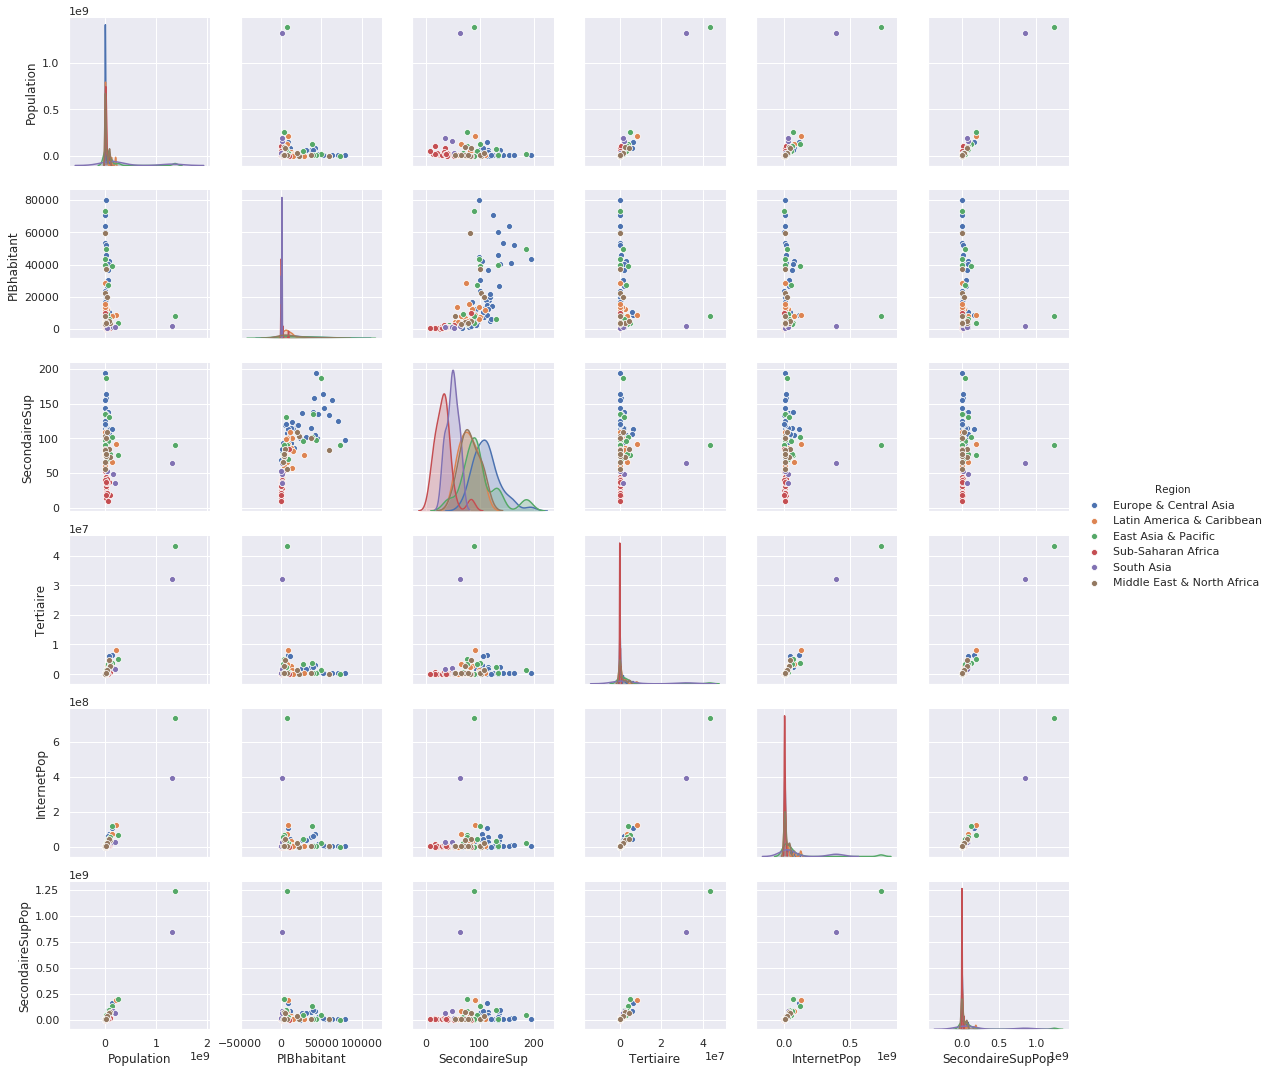

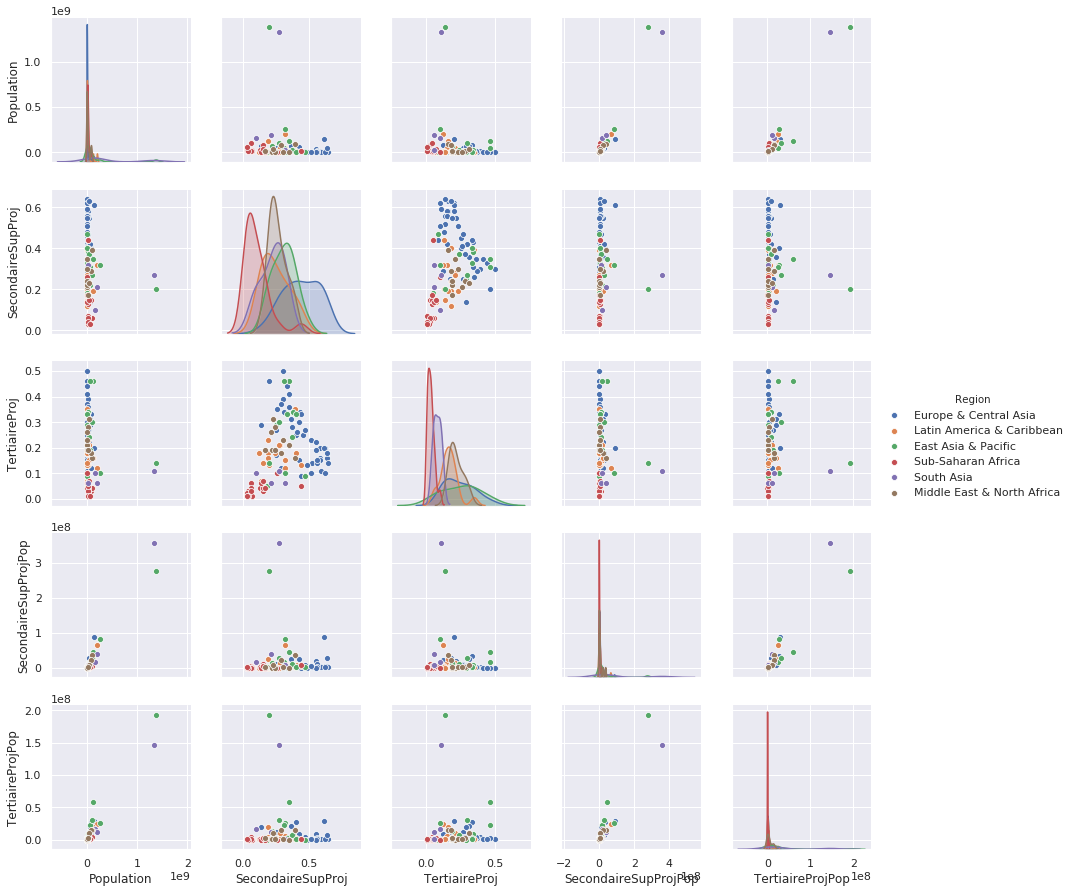

In [0]:
# Pairplot avec tous les indicateurs
datagraphplot=datagraph.dropna()
datagraphplot=datagraphplot[['Region','Population', 'PIBhabitant','SecondaireSup', 'Tertiaire', 'SecondaireSupProj', 'TertiaireProj','InternetPop', 'SecondaireSupPop', 'SecondaireSupProjPop','TertiaireProjPop']]
print (datagraphplot.groupby(['Region']).count())
masque=datagraphplot['Region']!='North America'
datagraphplotnan=datagraphplot[masque]
sns.set()
sns.pairplot(datagraphplotnan,hue='Region',vars=['Population', 'PIBhabitant','SecondaireSup', 'Tertiaire','InternetPop', 'SecondaireSupPop'])
sns.pairplot(datagraphplotnan,hue='Region',vars=['Population','SecondaireSupProj', 'TertiaireProj','SecondaireSupProjPop','TertiaireProjPop'])



Si nous étudions les pays en fonction du niveau d'étude, du PIB et de la taille totale de leur population, nous pouvons distinguer deux éléments :


*   L'étude du PIB par habitant par rapport au niveau d'étude des habitants ne donne pas de résultats très concluants. Pour le premier graphique, les deux pays ayant le plus d'habitants au niveau secondaire supérieur n'ont pas un PIB par habitant très haut, ce qui limite potentiellement leur intérêt pour Academy. Le deuxième graphique affiche les mêmes pays en résultats.
*   La comparaison de ces deux éléments confirme cependant les deux graphiques précédents, et il pourrait être intéressant de conserver ces trois pays qui sortent du lot : il s'agit de la Chine, de l'Inde et des Etats-Unis.

L'étude de l'accès à Internet nous donne les mêmes conclusions.



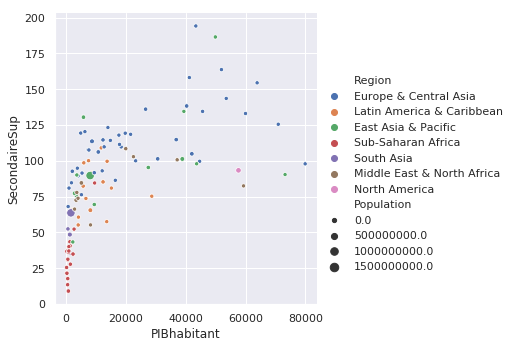

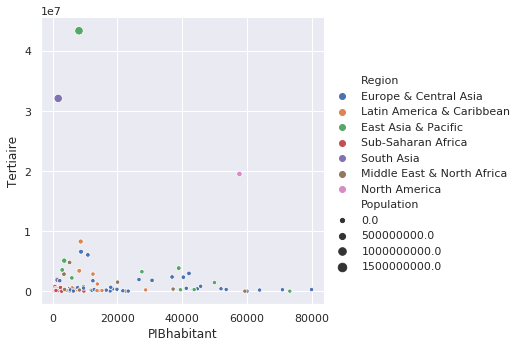

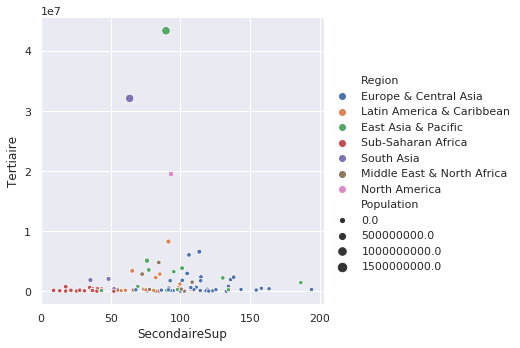

In [0]:
# Graphiques représentant les pays selon leur PIB, leur niveau d'études (secondaire supérieur et tertiaire) et la population totale des pays. 

sns.relplot(x="PIBhabitant", y="SecondaireSup",hue="Region",size="Population",data=datagraphplot);
sns.relplot(x="PIBhabitant", y="Tertiaire",hue="Region",size="Population",data=datagraphplot);
sns.relplot(x="SecondaireSup", y="Tertiaire",hue="Region",size="Population",data=datagraphplot);

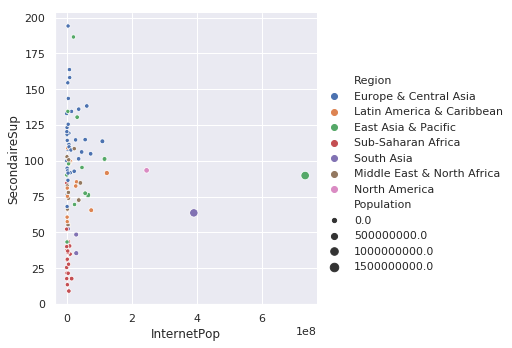

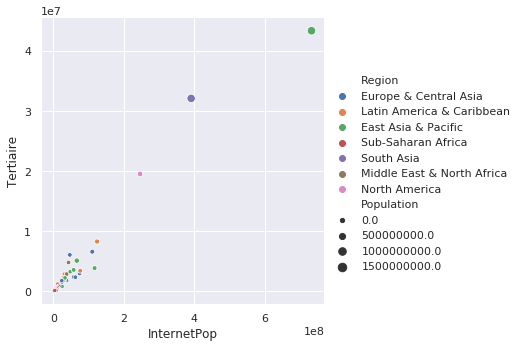

In [0]:
sns.relplot(x="InternetPop", y="SecondaireSup",hue="Region",size="Population",data=datagraphplot);
sns.relplot(x="InternetPop", y="Tertiaire",hue="Region",size="Population",data=datagraphplot);

In [0]:
highter=sorted(datagraphplot["Tertiaire"].values, reverse=True)
high=highter[0:3]

masque=datagraph['Tertiaire'].isin(high)
interestcountries=datagraph[masque]
print (interestcountries)

    CountryCode      ShortName  ... SecondaireSupProjPop  TertiaireProjPop
26          CHN          China  ...          2.75733e+08       1.93013e+08
65          IND          India  ...          3.57526e+08       1.45659e+08
158         USA  United States  ...          1.29251e+08       1.03401e+08

[3 rows x 14 columns]


Lorsque nous étudions les projections des personnes atteignant les niveau d'études d'intérêt pour notre entreprise, nous pouvons que, si les trois mêmes pays reviennent, un pays s'ajoute également : le Japon. Nous pouvons également voir que, si le nombre de personnes atteignant le niveau secondaire est en décroissance, un plus grand nombre de personnes atteignent finalement le niveau tertiaire.



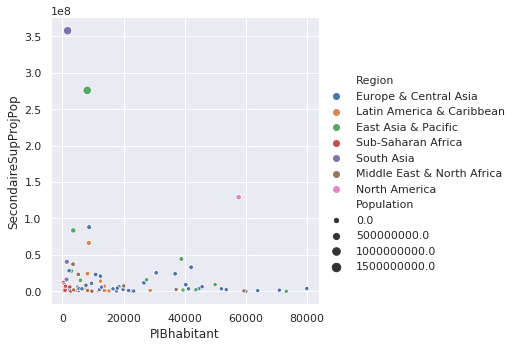

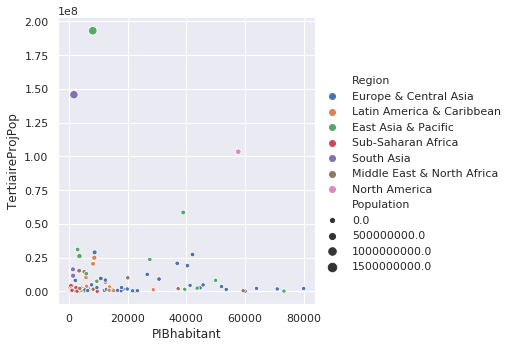

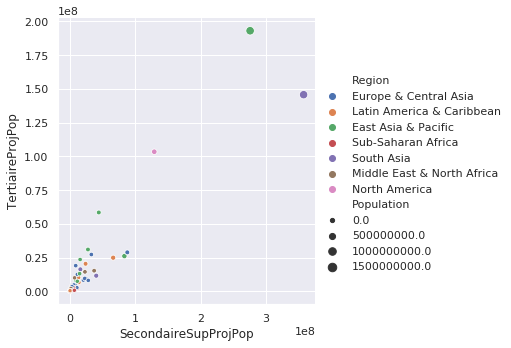

In [0]:
# Graphiques représentant les pays selon leur PIB, leur niveau d'études (secondaire supérieur et tertiaire) et la population totale des pays. 

sns.relplot(x="PIBhabitant", y="SecondaireSupProjPop",hue="Region",size="Population",data=datagraphplot);
sns.relplot(x="PIBhabitant", y="TertiaireProjPop",hue="Region",size="Population",data=datagraphplot);
sns.relplot(x="SecondaireSupProjPop", y="TertiaireProjPop",hue="Region",size="Population",data=datagraphplot);

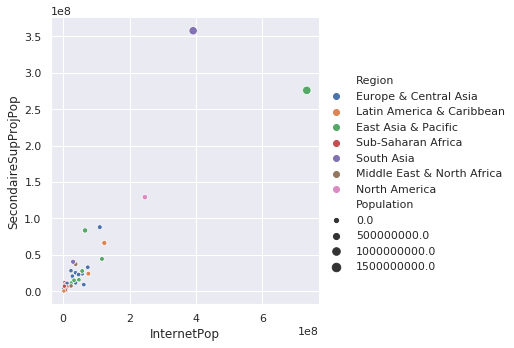

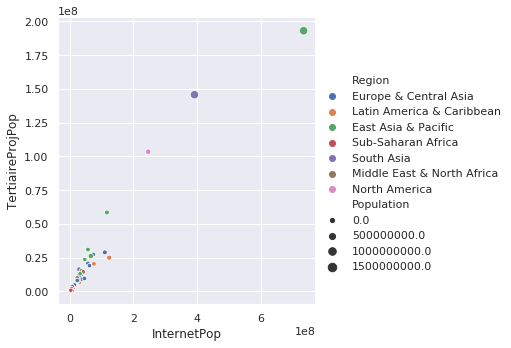

In [0]:
sns.relplot(x="InternetPop", y="SecondaireSupProjPop",hue="Region",size="Population",data=datagraphplot);
sns.relplot(x="InternetPop", y="TertiaireProjPop",hue="Region",size="Population",data=datagraphplot);


In [0]:
highterproj=sorted(datagraphplot["TertiaireProjPop"].values, reverse=True)
highproj=highterproj[0:4]

masque=datagraph['TertiaireProjPop'].isin(highproj)
interestcountriesfutur=datagraph[masque]
print (interestcountriesfutur[["ShortName","SecondaireSupPop","SecondaireSupProjPop"]])
print ("")
print (interestcountriesfutur[["ShortName","Tertiaire","TertiaireProjPop"]])
print ("")
print (interestcountriesfutur[["ShortName","Internet"]])

         ShortName SecondaireSupPop SecondaireSupProjPop
26           China        1.236e+09          2.75733e+08
65           India      8.42073e+08          3.57526e+08
74           Japan      1.28556e+08          4.44481e+07
158  United States      3.01435e+08          1.29251e+08

         ShortName    Tertiaire TertiaireProjPop
26           China  4.33674e+07      1.93013e+08
65           India  3.21074e+07      1.45659e+08
74           Japan  3.86246e+06      5.84175e+07
158  United States  1.95317e+07      1.03401e+08

         ShortName Internet
26           China     53.2
65           India  29.5472
74           Japan       92
158  United States  76.1767


# Conclusion

Nous avons donc effectué une étude afin de trouver les pays avec un fort potentiel de clients. Nous en avons ainsi détecté quatre différents, dans cet ordre de priorité :


1.   Le Japon : en effet, si ce pays n'était pas dans ceux ressortant pour les valeurs actuelles de niveau lycée et universitaire, son évolution dans les années futures le rend particulièrement intéressant à investir dès maintenant afin de mieux intégrer le marché. De plus, c'est un pays extrêmement connecté à Internet (>90%) rendant donc le nombre de personnes potentiellement ciblables assez élevé.
2.   Les Etats-Unis : ce pays n'est certes que le 3ème dans notre liste de pays, mais l'implémentation dans un pays anglophone demandera moins de moyens à l'entreprise que le développement dans un pays asiatique. 
3.   La Chine : en plus d'être le pays avec le plus de personnes ayant atteint les niveaux d'étude nécessaires pour nos cours, ce pays est le plus connecté des deux pays restants de notre liste.
4.   L'Inde : ce pays a une très forte base de personnes pouvant être intéressées par les services d'Academy. Cependant, l'accès à Internet n'y est pas encore très développé, ce qui peut poser des soucis d'implémentation de nos services.

Il serait cependant également intéressant d'étudier d'autres facteurs dans le futur, afin de confirmer ou d'infirmer cette liste de pays : étude des concurrents déjà implémentés, étude des moyens réels à déployer pour s'adapter au pays (traduction potentielle des cours pour l'Asie par exemple, effort moins coûteux pour les Etats-Unis).

